In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import os

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=sm.tools.sm_exceptions.ConvergenceWarning)
sns.set_style('whitegrid')

TARGET_INDEX_NAME = 'S&P_500_Return'
TARGET_FREQUENCY = 'M'
LAG_MACRO_FACTORS = True
TOP_N_REPORT = 3
TRAIN_WINDOW_SIZE = 60
TEST_WINDOW_SIZE = 12

print(" Setup Complete")

 Setup Complete


In [3]:
import yfinance as yf
import pandas_datareader.data as pdr
import datetime

START_DATE = datetime.datetime(2010, 1, 1)

TICKER_MAP = {
    '^GSPC': TARGET_INDEX_NAME,
    '^VIX': 'VIX_Change',
    'CL=F': 'Oil_Return',
    'XLK': 'Tech_Sector_Return',
    'GC=F': 'Gold_Return',
    'XLF': 'Financial_Sector_Return'
}

print("Fetching market data...")
raw_daily_data = yf.download(list(TICKER_MAP.keys()), start=START_DATE)['Close']
daily_returns_df = raw_daily_data.pct_change().dropna()
daily_returns_df = daily_returns_df.rename(columns=TICKER_MAP)
daily_factors_df = daily_returns_df.dropna()

print("Fetching macroeconomic data...")
cpi_data = pdr.get_data_fred('CPIAUCSL', start=START_DATE).pct_change().rename(columns={'CPIAUCSL': 'CPI_Change'})
fed_rate_data = pdr.get_data_fred('FEDFUNDS', start=START_DATE).rename(columns={'FEDFUNDS': 'Fed_Rate'})

index_returns = daily_factors_df[TARGET_INDEX_NAME]
market_factors = daily_factors_df.drop(columns=[TARGET_INDEX_NAME])
macro_factors = pd.concat([cpi_data, fed_rate_data], axis=1)

print(f"✓ Daily Data: {daily_factors_df.shape[0]} observations")
print(f"✓ Monthly Data: {macro_factors.shape[0]} observations")

Fetching market data...


[*********************100%***********************]  6 of 6 completed


Fetching macroeconomic data...
✓ Daily Data: 3999 observations
✓ Monthly Data: 190 observations


In [4]:
print("\n" + "="*60)
print("DATA PREPROCESSING AND ALIGNMENT")
print("="*60)

Y_daily = index_returns
X_market_daily = market_factors

Y_monthly = Y_daily.resample(TARGET_FREQUENCY).sum().rename(TARGET_INDEX_NAME)
X_market_monthly = X_market_daily.resample(TARGET_FREQUENCY).sum()
X_macro_monthly = macro_factors.resample(TARGET_FREQUENCY).last()

X_monthly = pd.concat([X_market_monthly, X_macro_monthly], axis=1)

if LAG_MACRO_FACTORS:
    X_monthly['CPI_Change_Lag1'] = X_monthly['CPI_Change'].shift(1)
    X_monthly['Fed_Rate_Lag1'] = X_monthly['Fed_Rate'].shift(1)
    X_monthly = X_monthly.drop(columns=['CPI_Change', 'Fed_Rate'])

df_model = pd.concat([Y_monthly, X_monthly], axis=1).dropna()
Y = df_model[TARGET_INDEX_NAME]
X = df_model.drop(columns=[TARGET_INDEX_NAME])

print(f"\n✓ Final Dataset: {df_model.shape[0]} months, {df_model.shape[1]} variables")
print(f"✓ Period: {df_model.index.min().strftime('%Y-%m')} to {df_model.index.max().strftime('%Y-%m')}")
print("\nSample Data:")
print(df_model.head(3).to_markdown())


DATA PREPROCESSING AND ALIGNMENT

✓ Final Dataset: 188 months, 8 variables
✓ Period: 2010-03 to 2025-10

Sample Data:
|                     |   S&P_500_Return |   Oil_Return |   Gold_Return |   Financial_Sector_Return |   Tech_Sector_Return |   VIX_Change |   CPI_Change_Lag1 |   Fed_Rate_Lag1 |
|:--------------------|-----------------:|-------------:|--------------:|--------------------------:|---------------------:|-------------:|------------------:|----------------:|
| 2010-03-31 00:00:00 |        0.0574479 |    0.0521891 |    -0.0035968 |                 0.0858718 |            0.0665494 |   -0.0913375 |      -0.000951777 |            0.13 |
| 2010-04-30 00:00:00 |        0.0155537 |    0.0304848 |     0.0589553 |                 0.0158294 |            0.013291  |    0.31701   |       0.000331368 |            0.16 |
| 2010-05-31 00:00:00 |       -0.0814769 |   -0.145854  |     0.0280493 |                -0.0885884 |           -0.0734882 |    0.608947  |       0.000230041 |          

In [7]:
print("\n" + "="*60)
print("OLS REGRESSION AND FACTOR ATTRIBUTION")
print("="*60)

X_with_const = sm.add_constant(X)
ols_model = sm.OLS(Y, X_with_const).fit()

print("\nModel Summary:")
print(ols_model.summary().as_text())

coefficients = ols_model.params.drop('const')
intercept = ols_model.params['const']

attribution_df = X.mul(coefficients, axis=1)
attribution_df['Intercept'] = intercept
attributed_return = attribution_df.sum(axis=1)
residual_return = Y - attributed_return
attribution_df['Residual'] = residual_return
attribution_df['Total_Actual_Return'] = Y

print("\n✓ Factor Attribution Complete")
print("\nAttribution Sample:")
print(attribution_df.head(3).to_markdown())


OLS REGRESSION AND FACTOR ATTRIBUTION

Model Summary:
                            OLS Regression Results                            
Dep. Variable:         S&P_500_Return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     628.1
Date:                Sun, 23 Nov 2025   Prob (F-statistic):          7.33e-123
Time:                        06:30:23   Log-Likelihood:                 639.35
No. Observations:                 188   AIC:                            -1263.
Df Residuals:                     180   BIC:                            -1237.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------


MODEL PERFORMANCE VISUALIZATION


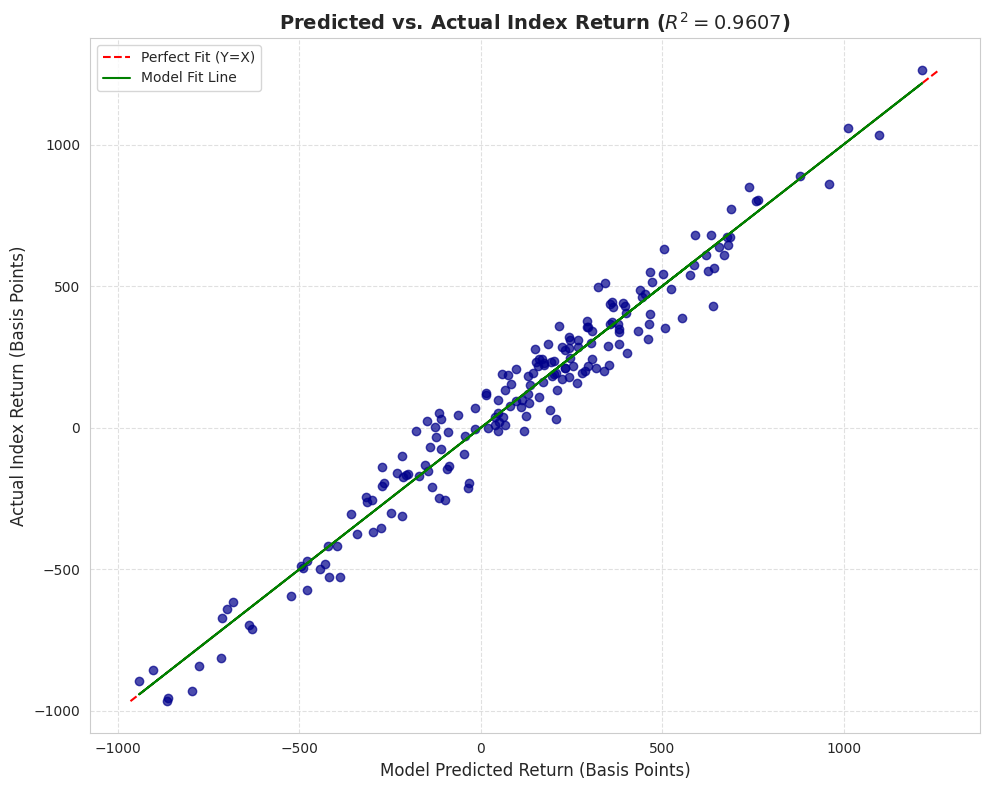

In [8]:
from scipy.stats import linregress

print("\n" + "="*60)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*60)

Y_bp = Y * 10000
predicted_return_bp = (attributed_return) * 10000

plt.figure(figsize=(10, 8))
plt.scatter(predicted_return_bp, Y_bp, color='darkblue', alpha=0.7)

max_val = max(predicted_return_bp.max(), Y_bp.max())
min_val = min(predicted_return_bp.min(), Y_bp.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit (Y=X)')

slope, intercept_line, r_value, p_value, std_err = linregress(predicted_return_bp, Y_bp)
plt.plot(predicted_return_bp, intercept_line + slope*predicted_return_bp, 'g-', label='Model Fit Line')

plt.title(f'Predicted vs. Actual Index Return ($R^2={ols_model.rsquared:.4f}$)', fontsize=14, fontweight='bold')
plt.xlabel('Model Predicted Return (Basis Points)', fontsize=12)
plt.ylabel('Actual Index Return (Basis Points)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

print("\n" + "="*60)
print("HYPERPARAMETER TUNING (RIDGE, LASSO & ELASTICNET)")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-3, 1, 100)

print("\nOptimizing Ridge Regression...")
ridge_cv = RidgeCV(alphas=alphas, cv=tscv, scoring='neg_mean_squared_error', fit_intercept=True)
ridge_cv.fit(X_scaled, Y)
best_alpha_ridge = ridge_cv.alpha_

print("Optimizing Lasso Regression...")
lasso_cv = LassoCV(alphas=alphas, cv=tscv, n_jobs=-1, max_iter=50000)
lasso_cv.fit(X_scaled, Y)
best_alpha_lasso = lasso_cv.alpha_

print("Optimizing ElasticNet Regression...")
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
elasticnet_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=tscv, n_jobs=-1, max_iter=50000)
elasticnet_cv.fit(X_scaled, Y)
best_alpha_elasticnet = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_

print(f"\n✓ Optimal Ridge Alpha: {best_alpha_ridge:.4f}")
print(f"✓ Optimal Lasso Alpha: {best_alpha_lasso:.4f}")
print(f"✓ Optimal ElasticNet Alpha: {best_alpha_elasticnet:.4f}, L1 Ratio: {best_l1_ratio:.4f}")

ridge_model = Ridge(alpha=best_alpha_ridge, fit_intercept=True)
ridge_model.fit(X_scaled, Y)

lasso_model = Lasso(alpha=best_alpha_lasso, fit_intercept=True)
lasso_model.fit(X_scaled, Y)

elasticnet_model = ElasticNet(alpha=best_alpha_elasticnet, l1_ratio=best_l1_ratio, fit_intercept=True)
elasticnet_model.fit(X_scaled, Y)


HYPERPARAMETER TUNING (RIDGE, LASSO & ELASTICNET)

Optimizing Ridge Regression...
Optimizing Lasso Regression...
Optimizing ElasticNet Regression...

✓ Optimal Ridge Alpha: 6.8926
✓ Optimal Lasso Alpha: 0.0010
✓ Optimal ElasticNet Alpha: 0.0011, L1 Ratio: 0.7000


ElasticNet(alpha=np.float64(0.0010974987654930556), l1_ratio=np.float64(0.7))


COMPREHENSIVE MODEL COMPARISON (WALK-FORWARD)

Running walk-forward validation...
✓ Completed: 2015-03
✓ Completed: 2016-03
✓ Completed: 2017-03
✓ Completed: 2018-03
✓ Completed: 2019-03
✓ Completed: 2020-03
✓ Completed: 2021-03
✓ Completed: 2022-03
✓ Completed: 2023-03
✓ Completed: 2024-03

RESULTS: Average Out-of-Sample R² Comparison
|                     |          0 |
|:--------------------|-----------:|
| Lasso_R2            |  0.907832  |
| ElasticNet_R2       |  0.907688  |
| BayesianRidge_R2    |  0.864547  |
| Huber_R2            |  0.863217  |
| Ridge_R2            |  0.862607  |
| OLS_R2              |  0.861949  |
| GradientBoosting_R2 |  0.822787  |
| RandomForest_R2     |  0.809624  |
| SVR_R2              | -0.0741202 |

🏆 WINNER: Lasso Model (Avg R² = 0.9078)

✓ Results saved to model_results.json


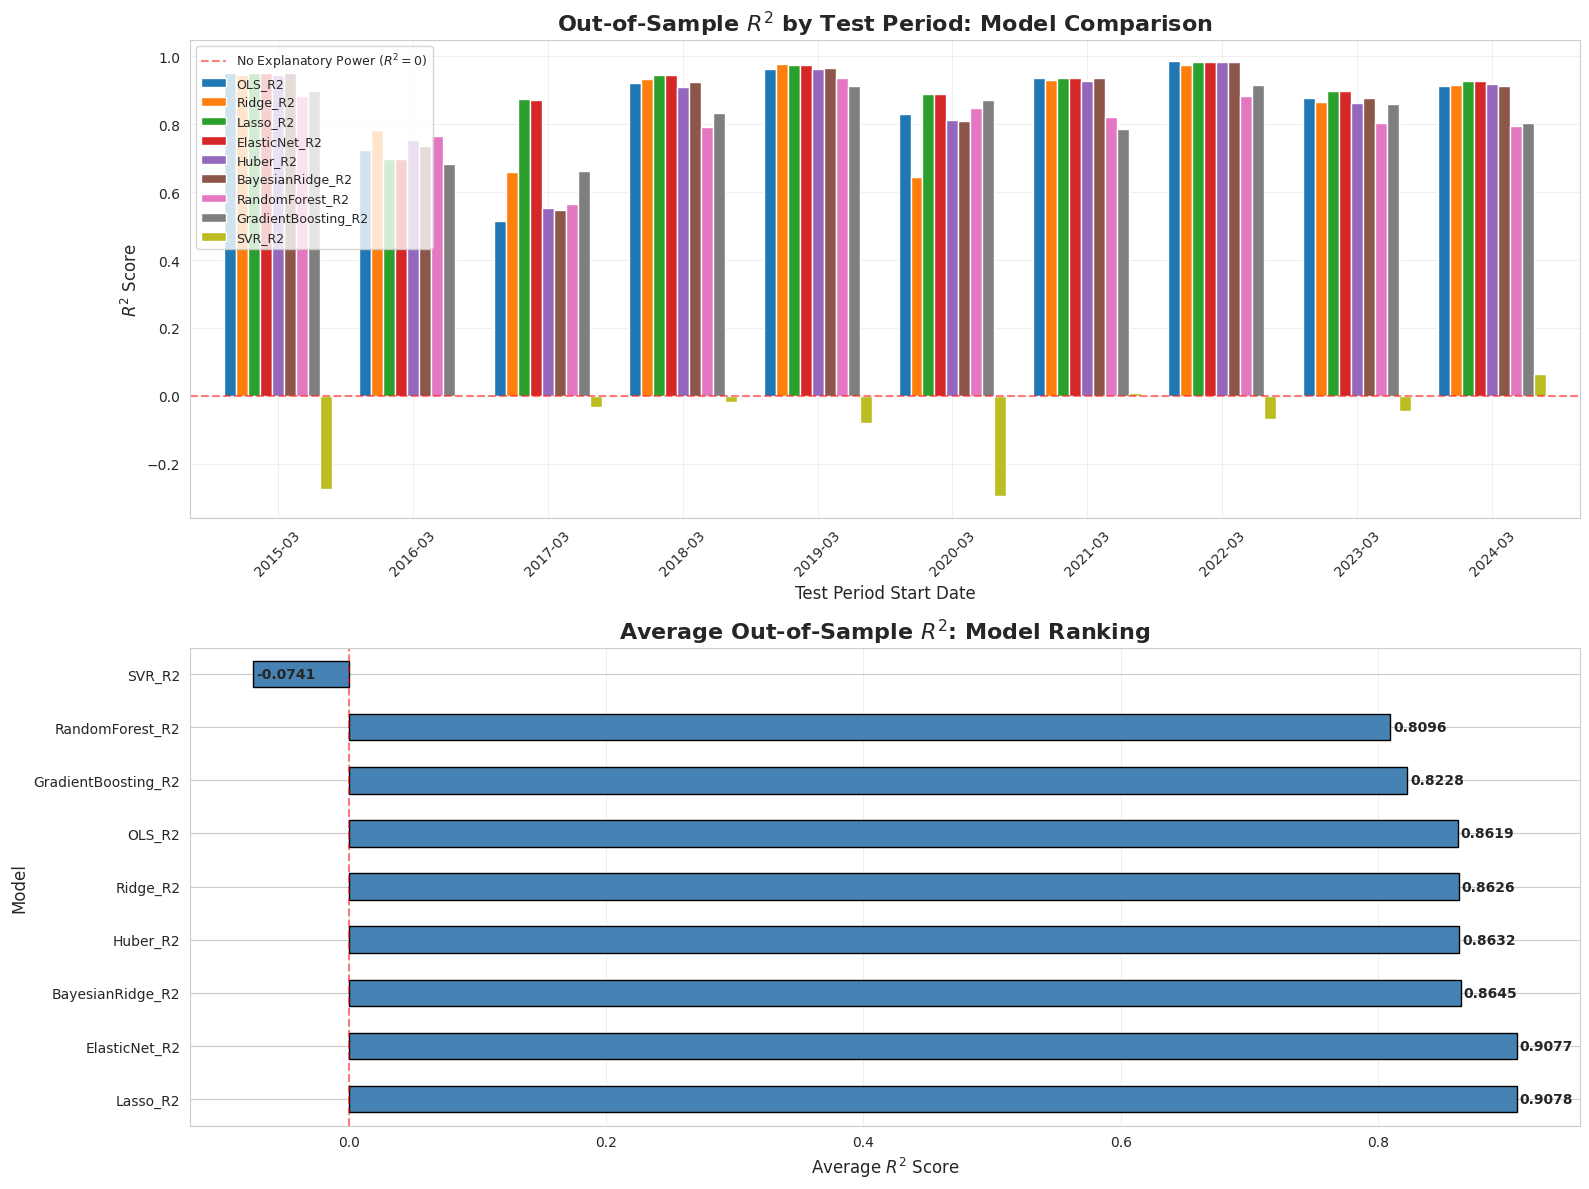


✓ Visualization saved to comprehensive_model_comparison.png


In [12]:
from sklearn.linear_model import ElasticNet, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

print("\n" + "="*60)
print("COMPREHENSIVE MODEL COMPARISON (WALK-FORWARD)")
print("="*60)

best_alpha_ridge = 6.8926
best_alpha_lasso = 0.0010
best_alpha_elasticnet = 0.0010
best_l1_ratio = 0.99

model_templates = {
    'OLS': sm.OLS,
    'Ridge': Ridge(alpha=best_alpha_ridge, fit_intercept=True),
    'Lasso': Lasso(alpha=best_alpha_lasso, fit_intercept=True),
    'ElasticNet': ElasticNet(alpha=best_alpha_elasticnet, l1_ratio=best_l1_ratio, fit_intercept=True, max_iter=50000),
    'Huber': HuberRegressor(epsilon=1.35, max_iter=1000),
    'BayesianRidge': BayesianRidge(compute_score=True),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

scaler = StandardScaler()
results = []

print("\nRunning walk-forward validation...")
for start in range(0, len(X) - TRAIN_WINDOW_SIZE, TEST_WINDOW_SIZE):
    end_train = start + TRAIN_WINDOW_SIZE
    end_test = end_train + TEST_WINDOW_SIZE
    if end_test > len(X):
        break

    X_train, Y_train = X.iloc[start:end_train], Y.iloc[start:end_train]
    X_test, Y_test = X.iloc[end_train:end_test], Y.iloc[end_train:end_test]

    window_results = {'Test_Start': Y_test.index.min().strftime('%Y-%m')}
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model_template in model_templates.items():
        try:
            if name == 'OLS':
                model = model_template(Y_train, sm.add_constant(X_train)).fit()
                Y_pred = model.predict(sm.add_constant(X_test))
            else:
                model = model_template.fit(X_train_scaled, Y_train)
                Y_pred = model.predict(X_test_scaled)

            window_results[name + '_R2'] = r2_score(Y_test, Y_pred)
        except Exception as e:
            window_results[name + '_R2'] = np.nan
            print(f"Warning: {name} failed for window {Y_test.index.min().strftime('%Y-%m')}")

    results.append(window_results)
    print(f"✓ Completed: {Y_test.index.min().strftime('%Y-%m')}")

comparison_df = pd.DataFrame(results)
average_r2 = comparison_df.drop(columns=['Test_Start']).mean().sort_values(ascending=False)

best_model_name = average_r2.index[0].replace('_R2', '')
best_model_r2 = average_r2.iloc[0]

print("\n" + "="*60)
print("RESULTS: Average Out-of-Sample R² Comparison")
print("="*60)
print(average_r2.to_markdown())
print(f"\n🏆 WINNER: {best_model_name} Model (Avg R² = {best_model_r2:.4f})")

total_attribution = attribution_df.drop(columns=['Total_Actual_Return']).sum().to_dict()

json_output = {
    "model_details": {
        "type": "Multi-Model Comparison",
        "best_model": best_model_name,
        "OLS_R_squared_adj": ols_model.rsquared_adj,
        "Total_Periods": df_model.shape[0],
    },
    "factor_coefficients": ols_model.params.to_dict(),
    "attribution_summary": {
        "Total_Index_Return": attribution_df['Total_Actual_Return'].sum(),
        "Total_Explained_Return": attributed_return.sum(),
        "Total_Residual_Return": attribution_df['Residual'].sum(),
        "factor_contributions_total": total_attribution
    },
    "model_comparison": {
        'Best_Model': best_model_name,
        'Best_Avg_OOS_R2': best_model_r2,
        'All_Models_Avg_OOS_R2': average_r2.to_dict(),
        'Total_Test_Windows': len(results)
    }
}

with open('model_results.json', 'w') as f:
    json.dump(json_output, f, indent=4)
print("\n✓ Results saved to model_results.json")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

comparison_df.set_index('Test_Start').plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Out-of-Sample $R^2$ by Test Period: Model Comparison', fontsize=16, fontweight='bold')
ax1.set_ylabel('$R^2$ Score', fontsize=12)
ax1.set_xlabel('Test Period Start Date', fontsize=12)
ax1.axhline(0, color='r', linestyle='--', alpha=0.5, label='No Explanatory Power ($R^2=0$)')
ax1.legend(loc='upper left', fontsize=9)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

average_r2.plot(kind='barh', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title('Average Out-of-Sample $R^2$: Model Ranking', fontsize=16, fontweight='bold')
ax2.set_xlabel('Average $R^2$ Score', fontsize=12)
ax2.set_ylabel('Model', fontsize=12)
ax2.axvline(0, color='r', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='x')

for i, v in enumerate(average_r2.values):
    ax2.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to comprehensive_model_comparison.png")

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet, HuberRegressor, BayesianRidge, Ridge, Lasso # Added Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd

print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE METRICS")
print("="*60)

performance_metrics = []

# Re-define model_templates and optimal alphas/l1_ratio for robustness
# (These values are taken from the best found in previous cells _6GCOxl8Edpm and R2JZDrMcdgPj)
best_alpha_ridge = 6.8926
best_alpha_lasso = 0.0010
best_alpha_elasticnet = 0.0010
best_l1_ratio = 0.99

model_templates = {
    'OLS': sm.OLS,
    'Ridge': Ridge(alpha=best_alpha_ridge, fit_intercept=True),
    'Lasso': Lasso(alpha=best_alpha_lasso, fit_intercept=True, max_iter=50000),
    'ElasticNet': ElasticNet(alpha=best_alpha_elasticnet, l1_ratio=best_l1_ratio, fit_intercept=True, max_iter=50000),
    'Huber': HuberRegressor(epsilon=1.35, max_iter=1000),
    'BayesianRidge': BayesianRidge(compute_score=True),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Scale the full dataset X once for all sklearn models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for name, model_template in model_templates.items():
    Y_pred_full = None
    if name == 'OLS':
        # OLS uses unscaled data and requires a constant
        X_with_const_full = sm.add_constant(X)
        # Fit OLS model on the full dataset
        current_model = model_template(Y, X_with_const_full).fit()
        Y_pred_full = current_model.predict(X_with_const_full)
    else:
        # Sklearn models use scaled data
        current_model = model_template # model_template is already an instantiated model
        # Fit sklearn model on the full dataset
        current_model.fit(X_scaled, Y)
        Y_pred_full = current_model.predict(X_scaled)

    metrics = {
        'Model': name,
        'R² Score': r2_score(Y, Y_pred_full),
        'RMSE': np.sqrt(mean_squared_error(Y, Y_pred_full)),
        'MAE': mean_absolute_error(Y, Y_pred_full),
        'RMSE (bps)': np.sqrt(mean_squared_error(Y, Y_pred_full)) * 10000,
        'MAE (bps)': mean_absolute_error(Y, Y_pred_full) * 10000
    }
    performance_metrics.append(metrics)

metrics_df = pd.DataFrame(performance_metrics).set_index('Model')
metrics_df = metrics_df.sort_values('R² Score', ascending=False)

print("\nIn-Sample Performance Metrics:")
print(metrics_df.to_markdown())

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
# best_model_name and best_model_r2 are expected to be in scope from cell R2JZDrMcdgPj
# results is also expected from cell R2JZDrMcdgPj
print(f"✓ Best In-Sample Model: {metrics_df.index[0]} (R² = {metrics_df.iloc[0]['R² Score']:.4f})")
print(f"✓ Best OOS Model: {best_model_name} (R² = {best_model_r2:.4f})")
print(f"✓ Lowest RMSE: {metrics_df['RMSE'].idxmin()} ({metrics_df['RMSE'].min():.6f})")
print(f"✓ Total Models Evaluated: {len(model_templates)}")
print(f"✓ Total Test Windows: {len(results)}")



COMPREHENSIVE PERFORMANCE METRICS

In-Sample Performance Metrics:
| Model            |   R² Score |       RMSE |        MAE |   RMSE (bps) |   MAE (bps) |
|:-----------------|-----------:|-----------:|-----------:|-------------:|------------:|
| GradientBoosting |  0.995866  | 0.00261609 | 0.00208471 |      26.1609 |     20.8471 |
| RandomForest     |  0.975142  | 0.00641506 | 0.00524382 |      64.1506 |     52.4382 |
| OLS              |  0.960672  | 0.00806898 | 0.006648   |      80.6898 |     66.48   |
| BayesianRidge    |  0.960668  | 0.00806937 | 0.00664728 |      80.6937 |     66.4728 |
| Huber            |  0.960522  | 0.0080844  | 0.00662628 |      80.844  |     66.2628 |
| Ridge            |  0.960196  | 0.00811768 | 0.00668183 |      81.1768 |     66.8183 |
| ElasticNet       |  0.958331  | 0.00830563 | 0.0069163  |      83.0563 |     69.163  |
| Lasso            |  0.958293  | 0.0083095  | 0.00691848 |      83.095  |     69.1848 |
| SVR              |  0.0636178 | 0.0393726


DETAILED MODEL ANALYSIS & FEATURE IMPORTANCE

Feature Importance/Coefficients by Model:
|                         |        Ridge |       Lasso |   ElasticNet |   RandomForest |   GradientBoosting |
|:------------------------|-------------:|------------:|-------------:|---------------:|-------------------:|
| Oil_Return              | -0.00115005  | -0.00012505 | -0.000134706 |     0.0103732  |         0.0100965  |
| Gold_Return             |  0.00296414  |  0.00195016 |  0.00195991  |     0.00800337 |         0.0121605  |
| Financial_Sector_Return |  0.016409    |  0.0161453  |  0.0161521   |     0.225774   |         0.319951   |
| Tech_Sector_Return      |  0.0209208   |  0.0215699  |  0.0215707   |     0.709584   |         0.604095   |
| VIX_Change              | -0.0068607   | -0.00579112 | -0.00579643  |     0.0368035  |         0.0482967  |
| CPI_Change_Lag1         |  0.000481092 |  0          |  0           |     0.00454308 |         0.00303466 |
| Fed_Rate_Lag1           | -0.

<Figure size 1400x800 with 0 Axes>

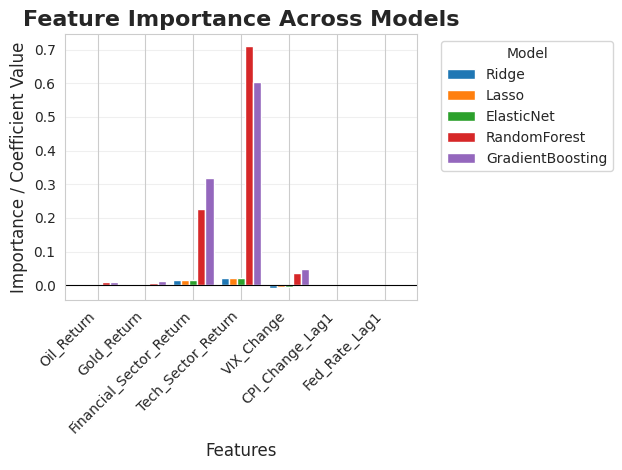


✓ Feature importance analysis complete


In [16]:
print("\n" + "="*60)
print("DETAILED MODEL ANALYSIS & FEATURE IMPORTANCE")
print("="*60)

scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X)

final_models = {
    'Ridge': Ridge(alpha=best_alpha_ridge, fit_intercept=True),
    'Lasso': Lasso(alpha=best_alpha_lasso, fit_intercept=True),
    'ElasticNet': ElasticNet(alpha=best_alpha_elasticnet, l1_ratio=best_l1_ratio, fit_intercept=True, max_iter=50000),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

feature_importance_df = pd.DataFrame(index=X.columns)

for name, model in final_models.items():
    model.fit(X_scaled_final, Y)

    if hasattr(model, 'coef_'):
        feature_importance_df[name] = model.coef_
    elif hasattr(model, 'feature_importances_'):
        feature_importance_df[name] = model.feature_importances_

print("\nFeature Importance/Coefficients by Model:")
print(feature_importance_df.to_markdown())

plt.figure(figsize=(14, 8))
feature_importance_df.plot(kind='bar', width=0.85)
plt.title('Feature Importance Across Models', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance / Coefficient Value', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8, linestyle='-')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()




FACTOR CONTRIBUTIONS OVER TIME


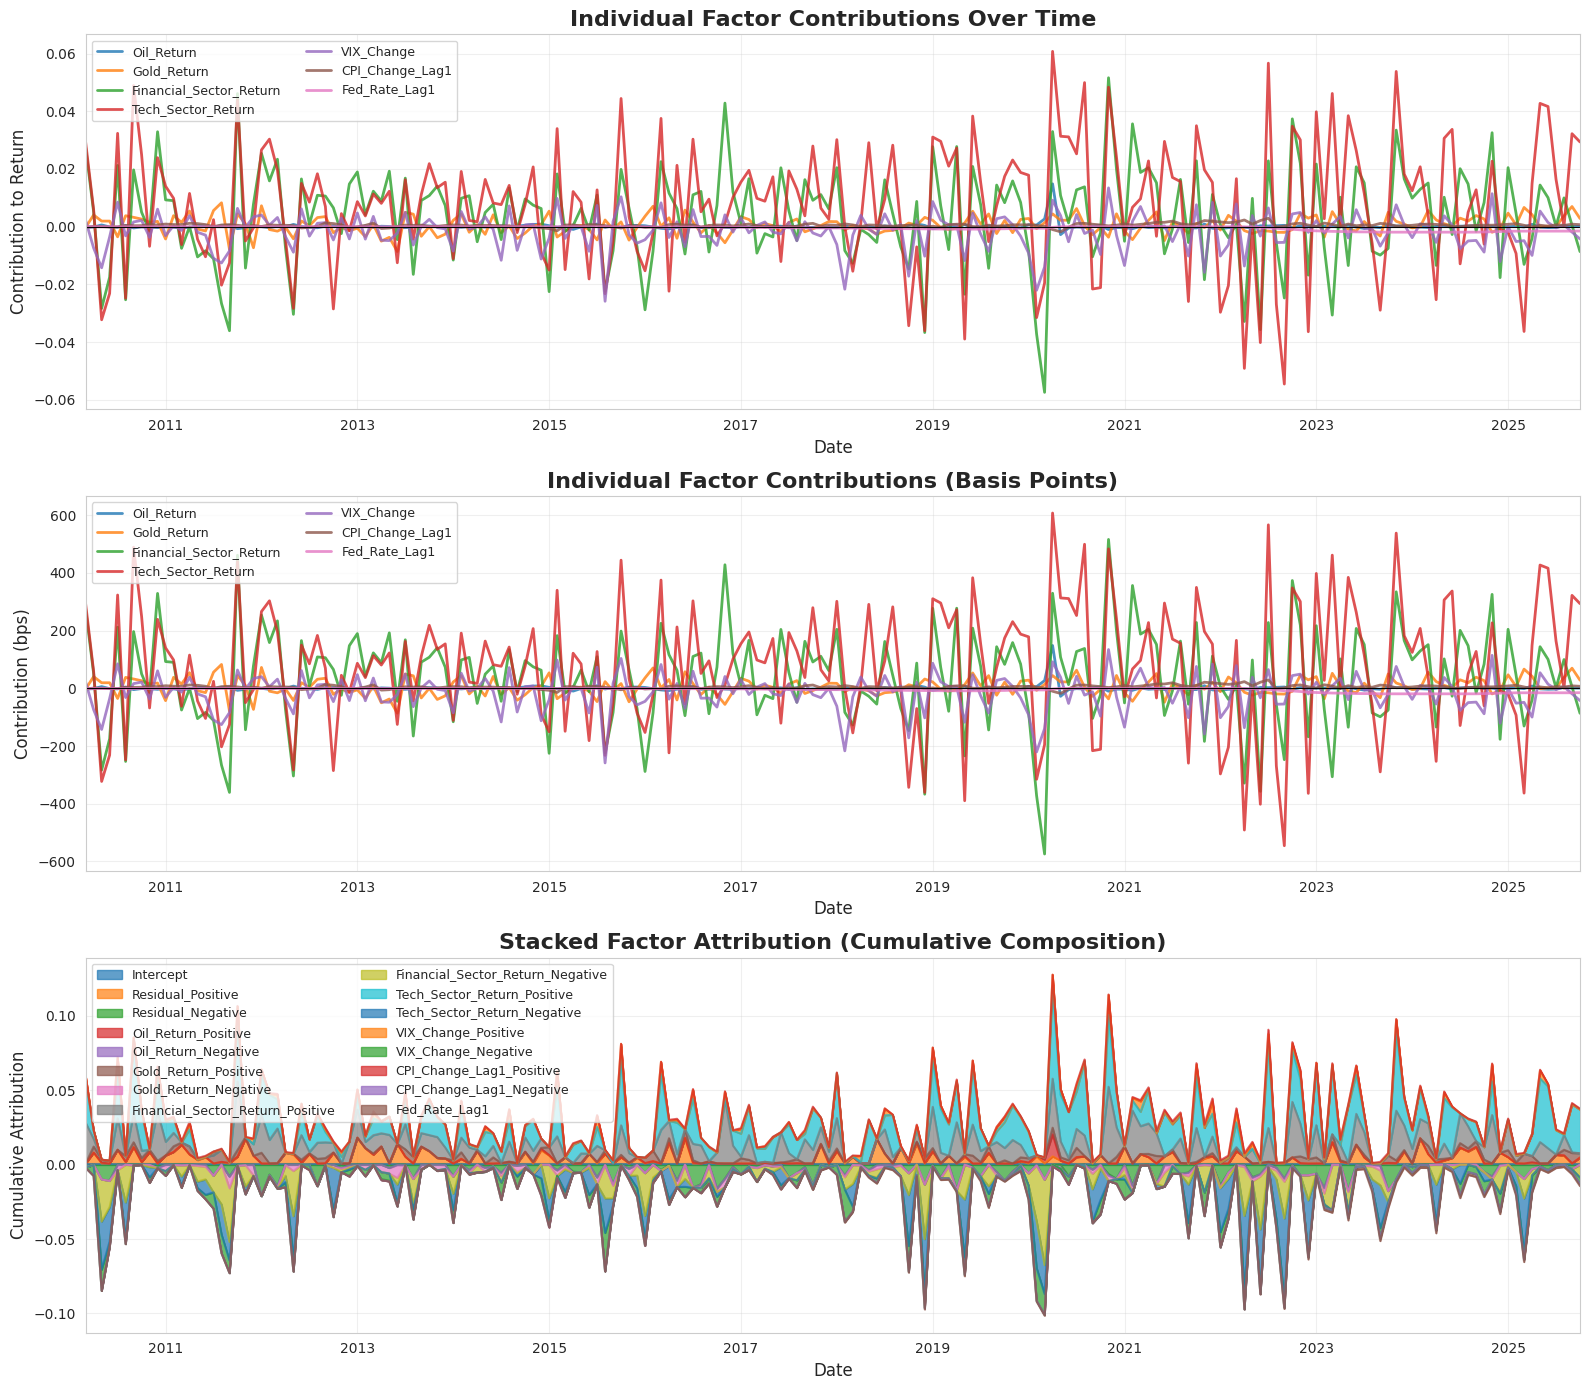


✓ Factor contributions visualization saved


In [18]:
print("\n" + "="*60)
print("FACTOR CONTRIBUTIONS OVER TIME")
print("="*60)

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

factor_cols = [col for col in attribution_df.columns if col not in ['Total_Actual_Return', 'Residual', 'Intercept']]
attribution_factors_only = attribution_df[factor_cols]

attribution_factors_only.plot(ax=axes[0], linewidth=2, alpha=0.8)
axes[0].set_title('Individual Factor Contributions Over Time', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Contribution to Return', fontsize=12)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].legend(loc='upper left', fontsize=9, ncol=2)
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[0].grid(True, alpha=0.3)

attribution_factors_only_bps = attribution_factors_only * 10000
attribution_factors_only_bps.plot(ax=axes[1], linewidth=2, alpha=0.8)
axes[1].set_title('Individual Factor Contributions (Basis Points)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Contribution (bps)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(loc='upper left', fontsize=9, ncol=2)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3)

# --- FIX FOR VALUEERROR: When stacked is True, each column must be either all positive or all negative ---
stacked_data_raw = attribution_df[factor_cols + ['Intercept', 'Residual']].copy()

# Create a new DataFrame to store split positive/negative components
stacked_data_processed = pd.DataFrame(index=stacked_data_raw.index)

# Handle Intercept and Residual, as they might have mixed signs or be consistently positive/negative
for col in ['Intercept', 'Residual']:
    if col in stacked_data_raw.columns:
        if stacked_data_raw[col].min() < 0 and stacked_data_raw[col].max() > 0:
            stacked_data_processed[f'{col}_Positive'] = stacked_data_raw[col].clip(lower=0)
            stacked_data_processed[f'{col}_Negative'] = stacked_data_raw[col].clip(upper=0)
        else:
            stacked_data_processed[col] = stacked_data_raw[col]

# Split factor columns into positive and negative parts for stacking
for col in factor_cols:
    if stacked_data_raw[col].min() < 0 and stacked_data_raw[col].max() > 0:
        stacked_data_processed[f'{col}_Positive'] = stacked_data_raw[col].clip(lower=0)
        stacked_data_processed[f'{col}_Negative'] = stacked_data_raw[col].clip(upper=0)
    else:
        stacked_data_processed[col] = stacked_data_raw[col]

# Plot the processed stacked data
stacked_data_processed.plot(kind='area', stacked=True, ax=axes[2], alpha=0.7)
axes[2].set_title('Stacked Factor Attribution (Cumulative Composition)', fontsize=16, fontweight='bold')
axes[2].set_ylabel('Cumulative Attribution', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend(loc='upper left', fontsize=9, ncol=2)
axes[2].grid(True, alpha=0.3)
# --- END FIX ---

plt.tight_layout()
plt.savefig('factor_contributions_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Factor contributions visualization saved")